# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 2 0 0]
 [0 0 0 1]
 [3 0 0 0]]
check?  0
dofk2  0

[[0 2 0 0]
 [0 0 0 0]
 [3 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 2 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [3 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 2 0 0]
 [0 0 1 0]
 [3 0 0 0]]
0.0  1
check?  0
dofk2  0


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.203 Number of steps:  7.056


# SARSA

In [30]:
np.random.seed(1)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUTPUT)

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# initialization of the network
xavier = False
weights = []
biases = []

layer_sizes = [N_in, N_h, N_a]

for idx in range(len(layer_sizes) - 1):
    if xavier:
        weights.append(
            np.random.randn(layer_sizes[idx + 1], layer_sizes[idx]) * np.sqrt(1 / (layer_sizes[idx])))
    else:
        weights.append(np.random.uniform(0, 1, (layer_sizes[idx + 1], layer_sizes[idx])))
        weights[idx] = np.divide(
            weights[idx],
            np.tile(np.sum(weights[idx], 1)[:, None], (1, layer_sizes[idx])), )

    biases.append(np.zeros((layer_sizes[idx + 1])))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [31]:
# define the epsilon - greedy policy

def EpsilonGreedy_Policy(Qvalues, epsilon):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:
        # random action with epsilon
        a=np.random.randint(0,N_a)

    else:
        # Greedy with probability epsilon
        a=np.argmax(Qvalues)
            
    return a

In [32]:
# Parameter to choose between the implemented algorithms
# SARSA

# the training loop is run N_episodes times
for n in range(N_episodes):
    
    if n%5000 == 0:
        print("Episode ", n)

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # get the initial state of the environment (initial board position)
    S,X,allowed_a=env.Initialise_game()   
    
    # network forward pass: the Q values are calculated as the output of the network feeded with
    # the features vector. The network has one hidden layer with 200 units and Relu as activation
    # function
    x = [X]
    h = []
    for idx in range(len(weights)):
        h.append(np.dot(weights[idx], x[-1]) + biases[idx])
        x.append(np.maximum(0, h[-1]))

    # pick an action from the allowed ones following the epsilon-greedy policy
    allowed_a_index,_=np.where(allowed_a==1)
    a = EpsilonGreedy_Policy(x[-1][allowed_a_index], epsilon_f) 
    taken_action = allowed_a_index[a]
    
    # while there is no check mate or draw
    while Done==0:                           
        
        Q_a = x[-1][taken_action]
                
        # take the chosen action: observe new values
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(taken_action)
        
        # if there is check mate or draw
        if Done==1:
            
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = R - Q_a * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * dweights[idx] * x[idx]
                biases[idx] += eta * dbiases[idx]
            
            # save the reward (check mate = 1; draw = 0) and the steps of the episode
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            
            break
        
        
        # if the game is not over
        else:
            
            # network forward pass to calculate the next Q values
            x_next = [X_next]
            h_next = []
            for idx in range(len(weights)):
                h_next.append(np.dot(weights[idx], x_next[-1]) + biases[idx])
                x_next.append(np.maximum(0, h_next[-1]))
            
            # pick a new action with epsilon-greedy policy
            allowed_a_index,_=np.where(allowed_a_next==1)
            a = EpsilonGreedy_Policy(x_next[-1][allowed_a_index],epsilon_f) 
            taken_action_next = allowed_a_index[a]
            Q_a_next = x_next[-1][taken_action_next]

            #update network parameters only for the action neuron (SARSA)
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = (R + gamma*Q_a_next - Q_a) * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * dweights[idx] * x[idx]
                biases[idx] += eta * dbiases[idx]
            
            
        # save values for the next step iteration   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        taken_action = np.copy(taken_action_next)
        for idx in range(len(h)):
            h[idx] = np.copy(h_next[idx])
            x[idx + 1] = np.copy(x_next[idx + 1])
        
        i += 1  # uptate the number of steps in the episode
    
    

Episode  0
Episode  5000
Episode  10000
Episode  15000
Episode  20000
Episode  25000
Episode  30000
Episode  35000
Episode  40000
Episode  45000
Episode  50000
Episode  55000
Episode  60000
Episode  65000
Episode  70000
Episode  75000
Episode  80000
Episode  85000
Episode  90000
Episode  95000


In [21]:
print('Total:')
print('Average reward:',np.mean(R_save[:]),'Number of steps: ',np.mean(N_moves_save[:]))
print('In the last 1000 episodes:')
print('Average reward:',np.mean(R_save[-1000:]),'Number of steps: ',np.mean(N_moves_save[-1000:]))

Total:
Average reward: 0.8332 Number of steps:  4.82331
In the last 1000 episodes:
Average reward: 0.971 Number of steps:  2.847


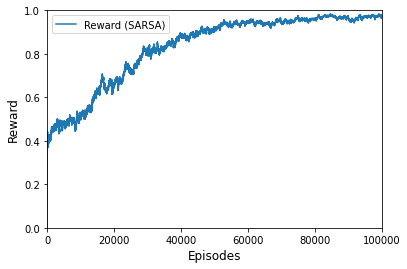

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

plt.xlim([0, N_episodes])
plt.ylim([0, 1])
plt.rcParams['axes.linewidth'] = 0.75
 
# dataframe
n_moves = pd.DataFrame({'Reward': list(R_save)})
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Reward (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
#plt.savefig('reward_SARSA_100000.pdf')

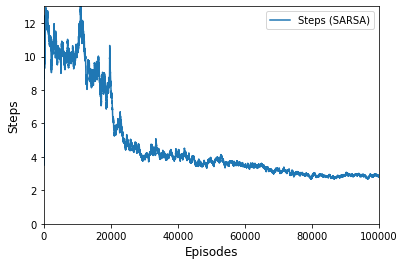

In [23]:
# dataframe
n_moves = pd.DataFrame({'N_moves_save': list(N_moves_save)})

plt.xlim([0, N_episodes])
plt.ylim([0, 13])
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Steps (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Steps", fontsize=12)
plt.legend()
#plt.savefig('steps_SARSA_100000.pdf')

# SARSA with Adam

In [35]:
class Adam:

    def __init__(self, Params, beta1):
        # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        N_dim = np.shape(np.shape(Params))[0]

        # INITIALISATION OF THE MOMENTUMS
        if N_dim == 1:
            self.N1 = np.shape(Params)[0]

            self.mt = np.zeros([self.N1])
            self.vt = np.zeros([self.N1])

        if N_dim == 2:
            self.N1 = np.shape(Params)[0]
            self.N2 = np.shape(Params)[1]

            self.mt = np.zeros([self.N1, self.N2])
            self.vt = np.zeros([self.N1, self.N2])

        # HYPERPARAMETERS OF ADAM
        self.beta1 = beta1
        self.beta2 = 0.999

        self.epsilon = 10 ** (-8)

        # COUNTER OF THE TRAINING PROCESS
        self.counter = 0

    def Compute(self, Grads):

        self.counter = self.counter + 1

        self.mt = self.beta1 * self.mt + (1 - self.beta1) * Grads

        self.vt = self.beta2 * self.vt + (1 - self.beta2) * Grads ** 2

        mt_n = self.mt / (1 - self.beta1 ** self.counter)
        vt_n = self.vt / (1 - self.beta2 ** self.counter)

        New_grads = mt_n / (np.sqrt(vt_n) + self.epsilon)

        return New_grads

In [41]:
np.random.seed(1)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUTPUT)

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# initialization of the network
xavier = False
weights = []
biases = []
adam_w = []
adam_b = []
beta_adam = 0.9

layer_sizes = [N_in, N_h, N_a]

for idx in range(len(layer_sizes) - 1):
    if xavier:
        weights.append(
            np.random.randn(layer_sizes[idx + 1], layer_sizes[idx]) * np.sqrt(1 / (layer_sizes[idx])))
    else:
        weights.append(np.random.uniform(0, 1, (layer_sizes[idx + 1], layer_sizes[idx])))
        weights[idx] = np.divide(
            weights[idx],
            np.tile(np.sum(weights[idx], 1)[:, None], (1, layer_sizes[idx])), )

    biases.append(np.zeros((layer_sizes[idx + 1])))
    
for idx in range(len(weights)):
    adam_w.append(Adam(weights[idx], beta_adam))
    adam_b.append(Adam(biases[idx], beta_adam))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 50000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [42]:
# Parameter to choose between the implemented algorithms
# SARSA

# the training loop is run N_episodes times
for n in range(N_episodes):
    
    if n%5000 == 0:
        print("Episode ", n)

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # get the initial state of the environment (initial board position)
    S,X,allowed_a=env.Initialise_game()   
    
    # network forward pass: the Q values are calculated as the output of the network feeded with
    # the features vector. The network has one hidden layer with 200 units and Relu as activation
    # function
    x = [X]
    h = []
    for idx in range(len(weights)):
        h.append(np.dot(weights[idx], x[-1]) + biases[idx])
        x.append(np.maximum(0, h[-1]))

    # pick an action from the allowed ones following the epsilon-greedy policy
    allowed_a_index,_=np.where(allowed_a==1)
    a = EpsilonGreedy_Policy(x[-1][allowed_a_index], epsilon_f) 
    taken_action = allowed_a_index[a]
    
    # while there is no check mate or draw
    while Done==0:                           
        
        Q_a = x[-1][taken_action]
                
        # take the chosen action: observe new values
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(taken_action)
        
        # if there is check mate or draw
        if Done==1:
            
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = R - Q_a * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * adam_w[idx].Compute(dweights[idx]) * x[idx]
                biases[idx] += eta * adam_b[idx].Compute(dbiases[idx])
            
            # save the reward (check mate = 1; draw = 0) and the steps of the episode
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            
            break
        
        
        # if the game is not over
        else:
            
            # network forward pass to calculate the next Q values
            x_next = [X_next]
            h_next = []
            for idx in range(len(weights)):
                h_next.append(np.dot(weights[idx], x_next[-1]) + biases[idx])
                x_next.append(np.maximum(0, h_next[-1]))
            
            # pick a new action with epsilon-greedy policy
            allowed_a_index,_=np.where(allowed_a_next==1)
            a = EpsilonGreedy_Policy(x_next[-1][allowed_a_index],epsilon_f) 
            taken_action_next = allowed_a_index[a]
            Q_a_next = x_next[-1][taken_action_next]

            #update network parameters only for the action neuron (SARSA)
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = (R + gamma*Q_a_next - Q_a) * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * adam_w[idx].Compute(dweights[idx]) * x[idx]
                biases[idx] += eta * adam_b[idx].Compute(dbiases[idx])
            
            
        # save values for the next step iteration   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        taken_action = np.copy(taken_action_next)
        for idx in range(len(h)):
            h[idx] = np.copy(h_next[idx])
            x[idx + 1] = np.copy(x_next[idx + 1])
        
        i += 1  # uptate the number of steps in the episode

Episode  0
Episode  5000
Episode  10000
Episode  15000
Episode  20000
Episode  25000
Episode  30000
Episode  35000
Episode  40000
Episode  45000


In [43]:
print('Total:')
print('Average reward:',np.mean(R_save[:]),'Number of steps: ',np.mean(N_moves_save[:]))
print('In the last 1000 episodes:')
print('Average reward:',np.mean(R_save[-1000:]),'Number of steps: ',np.mean(N_moves_save[-1000:]))

Total:
Average reward: 0.1881 Number of steps:  38.0171
In the last 1000 episodes:
Average reward: 0.189 Number of steps:  50.967


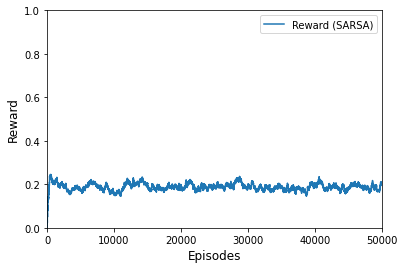

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

plt.xlim([0, N_episodes])
plt.ylim([0, 1])
plt.rcParams['axes.linewidth'] = 0.75
 
# dataframe
n_moves = pd.DataFrame({'Reward': list(R_save)})
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Reward (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
#plt.savefig('reward_SARSA_100000.pdf')

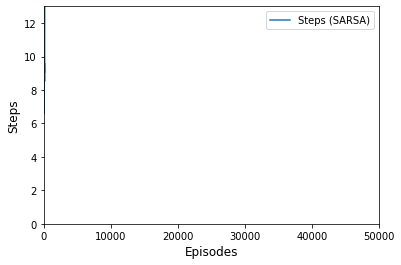

In [45]:
# dataframe
n_moves = pd.DataFrame({'N_moves_save': list(N_moves_save)})

plt.xlim([0, N_episodes])
plt.ylim([0, 13])
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Steps (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Steps", fontsize=12)
plt.legend()
#plt.savefig('steps_SARSA_100000.pdf')

# Q_LEARNING

In [46]:
np.random.seed(1)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUTPUT)

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# initialization of the network
xavier = False
weights = []
biases = []

layer_sizes = [N_in, N_h, N_a]

for idx in range(len(layer_sizes) - 1):
    if xavier:
        weights.append(
            np.random.randn(layer_sizes[idx + 1], layer_sizes[idx]) * np.sqrt(1 / (layer_sizes[idx])))
    else:
        weights.append(np.random.uniform(0, 1, (layer_sizes[idx + 1], layer_sizes[idx])))
        weights[idx] = np.divide(
            weights[idx],
            np.tile(np.sum(weights[idx], 1)[:, None], (1, layer_sizes[idx])), )

    biases.append(np.zeros((layer_sizes[idx + 1])))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [47]:
# Parameter to choose between the implemented algorithms
# Q-LEARNING

# the training loop is run N_episodes times
for n in range(N_episodes):
    
    if n%5000 == 0:
        print("Episode ", n)

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # get the initial state of the environment (initial board position)
    S,X,allowed_a=env.Initialise_game()   
    
    # network forward pass: the Q values are calculated as the output of the network feeded with
    # the features vector. The network has one hidden layer with 200 units and Relu as activation
    # function
    x = [X]
    h = []
    for idx in range(len(weights)):
        h.append(np.dot(weights[idx], x[-1]) + biases[idx])
        x.append(np.maximum(0, h[-1]))
    
    # while there is no check mate or draw
    while Done==0: 
        # pick an action from the allowed ones following the epsilon-greedy policy
        allowed_a_index,_=np.where(allowed_a==1)
        a = EpsilonGreedy_Policy(x[-1][allowed_a_index], epsilon_f) 
        taken_action = allowed_a_index[a]
        
        Q_a = x[-1][taken_action]
                
        # take the chosen action: observe new values
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(taken_action)
        
        # if there is check mate or draw
        if Done==1:
            
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = R - Q_a * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * dweights[idx] * x[idx]
                biases[idx] += eta * dbiases[idx]
            
            # save the reward (check mate = 1; draw = 0) and the steps of the episode
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            
            break
        
        
        # if the game is not over
        else:
            
            # network forward pass to calculate the next Q values
            x_next = [X_next]
            h_next = []
            for idx in range(len(weights)):
                h_next.append(np.dot(weights[idx], x_next[-1]) + biases[idx])
                x_next.append(np.maximum(0, h_next[-1]))
            
            # pick a new action with epsilon-greedy policy
            allowed_a_index,_=np.where(allowed_a_next==1)
            a_max = EpsilonGreedy_Policy(x_next[-1][allowed_a_index], 0) 
            taken_action_next = allowed_a_index[a_max]
            Q_a_next = x_next[-1][taken_action_next]

            #update network parameters only for the action neuron (SARSA)
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = (R + gamma*Q_a_next - Q_a) * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * dweights[idx] * x[idx]
                biases[idx] += eta * dbiases[idx]
            
            
        # save values for the next step iteration   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        for idx in range(len(h)):
            h[idx] = np.copy(h_next[idx])
            x[idx + 1] = np.copy(x_next[idx + 1])
        
        i += 1  # uptate the number of steps in the episode
    
    

Episode  0
Episode  5000
Episode  10000
Episode  15000
Episode  20000
Episode  25000
Episode  30000
Episode  35000
Episode  40000
Episode  45000
Episode  50000
Episode  55000
Episode  60000
Episode  65000
Episode  70000
Episode  75000
Episode  80000


C:\Users\tobia\AppData\Local\Temp/ipykernel_11580/1843605010.py:113: RuntimeWarning: invalid value encountered in multiply
  delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))


Episode  85000
Episode  90000
Episode  95000


In [48]:
print('Total:')
print('Average reward:',np.mean(R_save[:]),'Number of steps: ',np.mean(N_moves_save[:]))
print('In the last 1000 episodes:')
print('Average reward:',np.mean(R_save[-1000:]),'Number of steps: ',np.mean(N_moves_save[-1000:]))

Total:
Average reward: 0.12901 Number of steps:  28.75107
In the last 1000 episodes:
Average reward: 0.184 Number of steps:  86.944


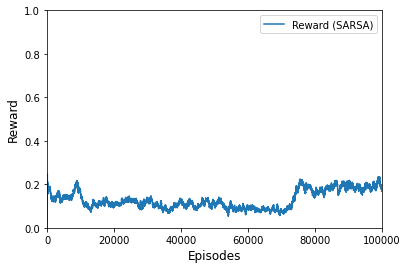

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

plt.xlim([0, N_episodes])
plt.ylim([0, 1])
plt.rcParams['axes.linewidth'] = 0.75
 
# dataframe
n_moves = pd.DataFrame({'Reward': list(R_save)})
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Reward (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
#plt.savefig('reward_SARSA_100000.pdf')

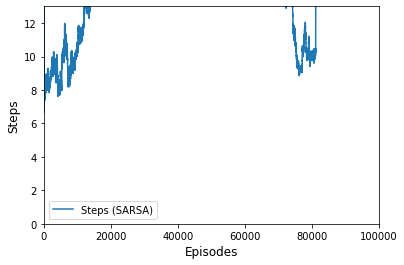

In [50]:
# dataframe
n_moves = pd.DataFrame({'N_moves_save': list(N_moves_save)})

plt.xlim([0, N_episodes])
plt.ylim([0, 13])
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Steps (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Steps", fontsize=12)
plt.legend()
#plt.savefig('steps_SARSA_100000.pdf')

# Q-LEARNING with Adam

In [ ]:
np.random.seed(1)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUTPUT)

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# initialization of the network
xavier = False
weights = []
biases = []
adam_w = []
adam_b = []
beta_adam = 0.9

layer_sizes = [N_in, N_h, N_a]

for idx in range(len(layer_sizes) - 1):
    if xavier:
        weights.append(
            np.random.randn(layer_sizes[idx + 1], layer_sizes[idx]) * np.sqrt(1 / (layer_sizes[idx])))
    else:
        weights.append(np.random.uniform(0, 1, (layer_sizes[idx + 1], layer_sizes[idx])))
        weights[idx] = np.divide(
            weights[idx],
            np.tile(np.sum(weights[idx], 1)[:, None], (1, layer_sizes[idx])), )

    biases.append(np.zeros((layer_sizes[idx + 1])))
    
for idx in range(len(weights)):
    adam_w.append(Adam(weights[idx], beta_adam))
    adam_b.append(Adam(biases[idx], beta_adam))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 50000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [ ]:
# Parameter to choose between the implemented algorithms
# SARSA

# the training loop is run N_episodes times
for n in range(N_episodes):
    
    if n%5000 == 0:
        print("Episode ", n)

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # get the initial state of the environment (initial board position)
    S,X,allowed_a=env.Initialise_game()   
    
    # network forward pass: the Q values are calculated as the output of the network feeded with
    # the features vector. The network has one hidden layer with 200 units and Relu as activation
    # function
    x = [X]
    h = []
    for idx in range(len(weights)):
        h.append(np.dot(weights[idx], x[-1]) + biases[idx])
        x.append(np.maximum(0, h[-1]))

    
    
    # while there is no check mate or draw
    while Done==0:     
        # pick an action from the allowed ones following the epsilon-greedy policy
        allowed_a_index,_=np.where(allowed_a==1)
        a = EpsilonGreedy_Policy(x[-1][allowed_a_index], epsilon_f) 
        taken_action = allowed_a_index[a]
        
        Q_a = x[-1][taken_action]
                
        # take the chosen action: observe new values
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(taken_action)
        
        # if there is check mate or draw
        if Done==1:
            
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = R - Q_a * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * adam_w[idx].Compute(dweights[idx]) * x[idx]
                biases[idx] += eta * adam_b[idx].Compute(dbiases[idx])
            
            # save the reward (check mate = 1; draw = 0) and the steps of the episode
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            
            break
        
        
        # if the game is not over
        else:
            
            # network forward pass to calculate the next Q values
            x_next = [X_next]
            h_next = []
            for idx in range(len(weights)):
                h_next.append(np.dot(weights[idx], x_next[-1]) + biases[idx])
                x_next.append(np.maximum(0, h_next[-1]))
            
            # pick a new action with epsilon-greedy policy
            allowed_a_index,_=np.where(allowed_a_next==1)
            a_max = EpsilonGreedy_Policy(x_next[-1][allowed_a_index], 0) 
            taken_action_next = allowed_a_index[a_max]
            Q_a_next = x_next[-1][taken_action_next]

            #update network parameters only for the action neuron (SARSA)
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = (R + gamma*Q_a_next - Q_a) * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * adam_w[idx].Compute(dweights[idx]) * x[idx]
                biases[idx] += eta * adam_b[idx].Compute(dbiases[idx])
            
            
        # save values for the next step iteration   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        for idx in range(len(h)):
            h[idx] = np.copy(h_next[idx])
            x[idx + 1] = np.copy(x_next[idx + 1])
        
        i += 1  # uptate the number of steps in the episode

In [ ]:
print('Total:')
print('Average reward:',np.mean(R_save[:]),'Number of steps: ',np.mean(N_moves_save[:]))
print('In the last 1000 episodes:')
print('Average reward:',np.mean(R_save[-1000:]),'Number of steps: ',np.mean(N_moves_save[-1000:]))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.xlim([0, N_episodes])
plt.ylim([0, 1])
plt.rcParams['axes.linewidth'] = 0.75
 
# dataframe
n_moves = pd.DataFrame({'Reward': list(R_save)})
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Reward (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
#plt.savefig('reward_SARSA_100000.pdf')

In [ ]:
# dataframe
n_moves = pd.DataFrame({'N_moves_save': list(N_moves_save)})

plt.xlim([0, N_episodes])
plt.ylim([0, 13])
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Steps (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Steps", fontsize=12)
plt.legend()
#plt.savefig('steps_SARSA_100000.pdf')

# DOUBLE-Q-LEARNING

In [ ]:
np.random.seed(1)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUTPUT)

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# initialization of the network
xavier = False
weights = []
biases = []

layer_sizes = [N_in, N_h, N_a]

for idx in range(len(layer_sizes) - 1):
    if xavier:
        weights.append(
            np.random.randn(layer_sizes[idx + 1], layer_sizes[idx]) * np.sqrt(1 / (layer_sizes[idx])))
    else:
        weights.append(np.random.uniform(0, 1, (layer_sizes[idx + 1], layer_sizes[idx])))
        weights[idx] = np.divide(
            weights[idx],
            np.tile(np.sum(weights[idx], 1)[:, None], (1, layer_sizes[idx])), )

    biases.append(np.zeros((layer_sizes[idx + 1])))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [ ]:
# Parameter to choose between the implemented algorithms
# Q-LEARNING

# the training loop is run N_episodes times
for n in range(N_episodes):
    
    if n%5000 == 0:
        print("Episode ", n)

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # get the initial state of the environment (initial board position)
    S,X,allowed_a=env.Initialise_game()   
    
    # network forward pass: the Q values are calculated as the output of the network feeded with
    # the features vector. The network has one hidden layer with 200 units and Relu as activation
    # function
    x = [X]
    h = []
    for idx in range(len(weights)):
        h.append(np.dot(weights[idx], x[-1]) + biases[idx])
        x.append(np.maximum(0, h[-1]))
    
    # while there is no check mate or draw
    while Done==0: 
        # pick an action from the allowed ones following the epsilon-greedy policy
        allowed_a_index,_=np.where(allowed_a==1)
        a = EpsilonGreedy_Policy(x[-1][allowed_a_index], epsilon_f) 
        taken_action = allowed_a_index[a]
        
        Q_a = x[-1][taken_action]
                
        # take the chosen action: observe new values
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(taken_action)
        
        # if there is check mate or draw
        if Done==1:
            
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = R - Q_a * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * dweights[idx] * x[idx]
                biases[idx] += eta * dbiases[idx]
            
            # save the reward (check mate = 1; draw = 0) and the steps of the episode
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            
            break
        
        
        # if the game is not over
        else:
            
            # network forward pass to calculate the next Q values
            x_next = [X_next]
            h_next = []
            for idx in range(len(weights)):
                h_next.append(np.dot(weights[idx], x_next[-1]) + biases[idx])
                x_next.append(np.maximum(0, h_next[-1]))
            
            # pick a new action with epsilon-greedy policy
            allowed_a_index,_=np.where(allowed_a_next==1)
            a_max = EpsilonGreedy_Policy(x_next[-1][allowed_a_index], 0) 
            taken_action_next = allowed_a_index[a_max]
            Q_a_next = x_next[-1][taken_action_next]

            #update network parameters only for the action neuron (SARSA)
            dweights = []
            dbiases = []

            action_taken = np.zeros(len(x[-1]))
            action_taken[a] = 1

            # update network parameters only for the action neuron
            e_n = (R + gamma*Q_a_next - Q_a) * action_taken

            # The parameters W2 and b2 are updated only for the taken action. For that, the filter
            #[taken_action] is applied
            for idx in range(len(weights)):
                dweights.append(np.zeros(weights[idx].shape))
                dbiases.append(np.zeros(biases[idx].shape))

            for idx in range(len(weights)):
                if idx == 0:
                    delta = x[-1] * (1 - x[-1]) * e_n
                else:
                    # TODO: delta falsch?
                    delta = (x[-(idx + 1)] * (1 - x[-(idx + 1)]) * np.dot(np.transpose(weights[-idx]), delta))
                dweights[-(idx + 1)] += np.outer(delta, x[-(idx + 2)])
                dbiases[-(idx + 1)] += delta
                
            for idx in range(len(weights)):
                weights[idx] += eta * dweights[idx] * x[idx]
                biases[idx] += eta * dbiases[idx]
            
            
        # save values for the next step iteration   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        for idx in range(len(h)):
            h[idx] = np.copy(h_next[idx])
            x[idx + 1] = np.copy(x_next[idx + 1])
        
        i += 1  # uptate the number of steps in the episode
    
    

In [ ]:
print('Total:')
print('Average reward:',np.mean(R_save[:]),'Number of steps: ',np.mean(N_moves_save[:]))
print('In the last 1000 episodes:')
print('Average reward:',np.mean(R_save[-1000:]),'Number of steps: ',np.mean(N_moves_save[-1000:]))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.xlim([0, N_episodes])
plt.ylim([0, 1])
plt.rcParams['axes.linewidth'] = 0.75
 
# dataframe
n_moves = pd.DataFrame({'Reward': list(R_save)})
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Reward (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
#plt.savefig('reward_SARSA_100000.pdf')

In [ ]:
# dataframe
n_moves = pd.DataFrame({'N_moves_save': list(N_moves_save)})

plt.xlim([0, N_episodes])
plt.ylim([0, 13])
 
ema = n_moves.ewm(com=400).mean()
 

plt.plot(ema, label="Steps (SARSA)")
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Steps", fontsize=12)
plt.legend()
#plt.savefig('steps_SARSA_100000.pdf')